<a href="https://colab.research.google.com/github/linhlinhle997/image-depth-estimation/blob/feature%2F01-image-depth/image__depth_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gdown 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
!unzip tsukuba -d tsukuba

In [ ]:
!gdown 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
!unzip Aloe_images

## Problem 1: Compute Disparity Map Using Pixel-Wise Matching

In [40]:
def plot_two_images(left_img_path, right_img_path):
    left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_img_path, cv2.IMREAD_COLOR)

    left_img = np.asarray(left_img, dtype=np.float32)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Plot images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(left_img, cmap='gray')
    plt.title('Left Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(right_img)
    plt.title('Right Image')
    plt.axis('off')
    plt.show()

In [64]:
def l1_distance(x, y):
    return abs(x - y)


def l2_distance(x, y):
    return np.sqrt((x - y) ** 2)

In [65]:
def pixel_wise_matching_l1(left_img, right_img, disparity_range, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    scale = 16
    max_value = 255

    for y in range(height):
        for x in range(width):
            # Find j where cost has minium value
            disparity = 0
            cost_min = max_value

            for j in range(disparity_range):
                cost = max_value if (x - j) < 0 else l1_distance(int(left[y, x]),
                                                              int(right[y, x-j]))
                if cost < cost_min:
                    cost_min = cost
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity * scale

    if save_result == True:
        print("Saving result...")
        cv2.imwrite(f"pixel_wise_l1.png", depth)
        cv2.imwrite(f"pixel_wise_l1_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print("Done.")
    return depth

In [66]:
def pixel_wise_matching_l2(left_img, right_img, disparity_range, save_result=True):
    # Read left and right images and convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)
    scale = 16
    max_value = 255

    for y in range(height):
        for x in range(width):
            # Find disparity where cost has minimum value
            disparity = 0
            cost_min = max_value ** 2  # L2 cost could be squared

            for j in range(disparity_range):
                if (x - j) < 0:
                    cost = max_value ** 2  # L2 cost could be squared
                else:
                    cost = l2_distance(left[y, x], right[y, x - j]) ** 2  # Compute squared L2 distance

                if cost < cost_min:
                    cost_min = cost
                    disparity = j

            # Let depth at (y, x) = disparity (j)
            # Multiply by a scale factor for visualization purposes
            depth[y, x] = disparity * scale

    if save_result:
        print("Saving result...")
        cv2.imwrite("pixel_wise_l2.png", depth)
        cv2.imwrite("pixel_wise_l2_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print("Done.")
    return depth

In [ ]:
left_img_path = "tsukuba/left.png"
right_img_path = "tsukuba/right.png"
disparity_range = 16

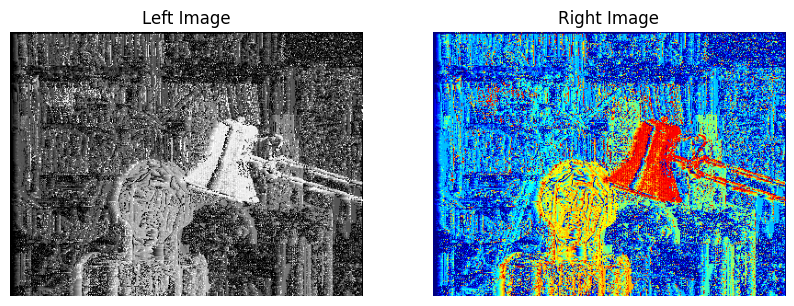

In [41]:
pixel_wise_result_l1 = pixel_wise_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    save_result=True
)
plot_two_images('pixel_wise_l1.png', 'pixel_wise_l1_color.png')

Saving result...
Done.


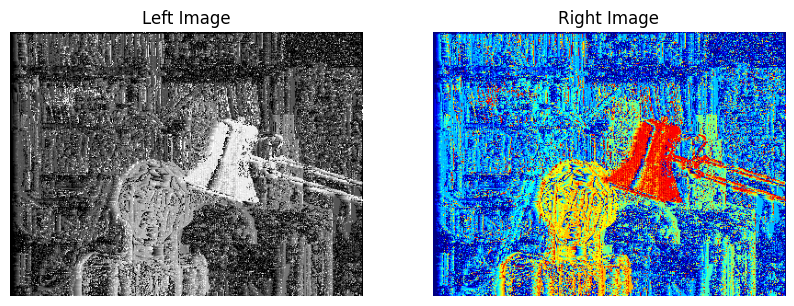

In [42]:
pixel_wise_result_l1 = pixel_wise_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    save_result=True
)
plot_two_images('pixel_wise_l2.png', 'pixel_wise_l2_color.png')

## Problem 2: Compute Disparity Map Using Window-Based Matching

In [67]:
def window_based_matching_l1(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255*9

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            # Find j where cost has minium value
            disparity = 0
            cost_min = 65534

            for j in range(disparity_range):
                total = 0
                value = 0

                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        value = max_value
                        if (x + u - j) >= 0:
                            value = l1_distance(int(left[y+v, x+u]), int(right[y+v, (x+u)-j]))
                        total += value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity*scale

    if save_result == True:
        print("Saving result...")
        cv2.imwrite(f"window_based_l1.png", depth)
        cv2.imwrite(f"window_based_l1_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print("Done.")
    return depth

In [71]:
def window_based_matching_l2(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3
    max_value = 255*9

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            # Find j where cost has minium value
            disparity = 0
            cost_min = np.inf

            for j in range(disparity_range):
                total = 0

                for v in range(-kernel_half, kernel_half + 1):
                    for u in range(-kernel_half, kernel_half + 1):
                        if (x + u - j) >= 0:
                            left_pixel = left[y + v, x + u]
                            right_pixel = right[y + v, (x + u) - j]
                            total += l2_distance(left_pixel, right_pixel)
                        else:
                            total += max_value

                if total < cost_min:
                    cost_min = total
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity*scale

    if save_result == True:
        print("Saving result...")
        cv2.imwrite(f"window_based_l2.png", depth)
        cv2.imwrite(f"window_based_l2_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print("Done.")
    return depth

In [69]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"
disparity_range = 64
kernel_size = 3

Saving result...
Done.


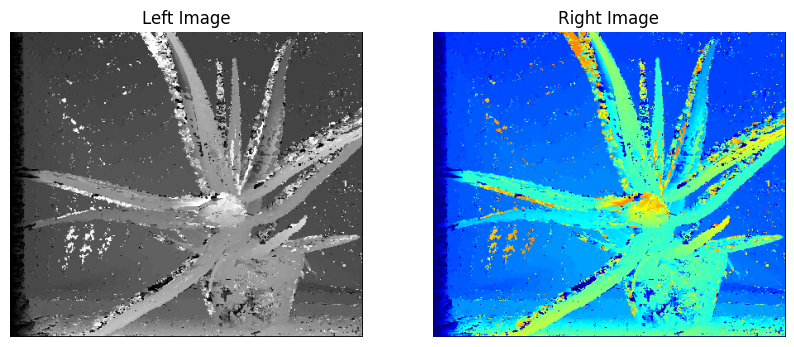

In [70]:
windown_based_result_l1 = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
plot_two_images('window_based_l1.png', 'window_based_l1_color.png')

Saving result...
Done.


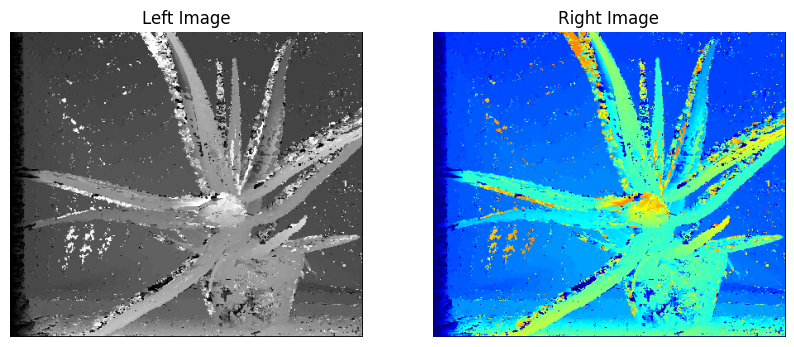

In [72]:
windown_based_result_l2 = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
plot_two_images('window_based_l2.png', 'window_based_l2_color.png')

## Problem 3: Recompute Disparity Map Using Window-Based Matching with Kernel Size 5 and Disparity Range 64

In [73]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"
disparity_range = 64
kernel_size = 5

Saving result...
Done.


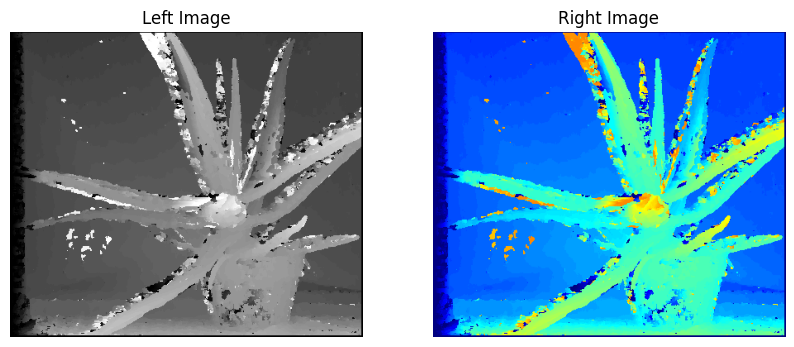

In [74]:
windown_based_result_l1 = window_based_matching_l1(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
plot_two_images('window_based_l1.png', 'window_based_l1_color.png')

Saving result...
Done.


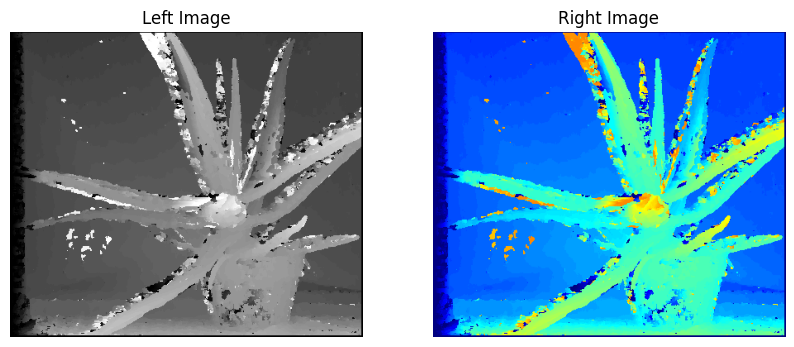

In [75]:
windown_based_result_l2 = window_based_matching_l2(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
plot_two_images('window_based_l2.png', 'window_based_l2_color.png')

## Problem 4: Compute Disparity Map Using Window-Based Matching with Cosine Similarity

In [76]:
def cosine_similarity(x, y):
    numerator = np.dot(x, y)
    denominator = np.linalg.norm(x) * np.linalg.norm(y)
    return numerator / denominator

In [77]:
def window_based_matching_cosine(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
    # Read left, right images then convert to grayscale
    left = cv2.imread(left_img, 0)
    right = cv2.imread(right_img, 0)

    left = left.astype(np.float32)
    right = right.astype(np.float32)

    height, width = left.shape[:2]

    # Create blank disparity map
    depth = np.zeros((height, width), np.uint8)

    kernel_half = int((kernel_size - 1) / 2)
    scale = 3

    for y in range(kernel_half, height - kernel_half):
        for x in range(kernel_half, width - kernel_half):
            # Find j where cost has minium value
            disparity = 0
            cost_optimal = -1

            for j in range(disparity_range):
                d = x - j
                cost = -1

                if (d - kernel_half) > 0:
                    wp = left[
                        (y - kernel_half) : (y + kernel_half) + 1,
                        (x - kernel_half) : (x + kernel_half) + 1
                    ]
                    wqd = right[
                        (y - kernel_half) : (y + kernel_half) + 1,
                        (d - kernel_half) : (d + kernel_half) + 1
                    ]

                    wp_flattened = wp.flatten()
                    wqd_flattened = wqd.flatten()

                    cost = cosine_similarity(wp_flattened, wqd_flattened)

                if cost > cost_optimal:
                    cost_optimal = cost
                    disparity = j

            # Let depth at (y, x) = j (disparity)
            # Multiply by a scale factor for visualization purpose
            depth[y, x] = disparity*scale

    if save_result == True:
        print("Saving result...")
        cv2.imwrite(f"/content/window_based_cosine_similarity.png", depth)
        cv2.imwrite(f"/content/window_based_cosine_similarity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))

    print("Done.")
    return depth

In [79]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"
disparity_range = 64
kernel_size = 5

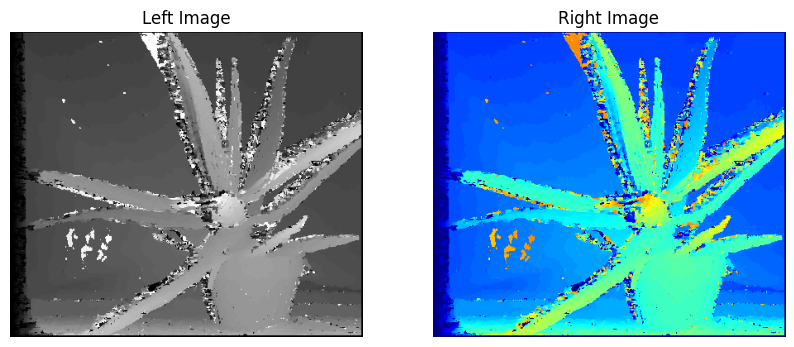

In [82]:
windown_based_result_cosine = window_based_matching_cosine(
    left_img_path,
    right_img_path,
    disparity_range,
    kernel_size=kernel_size,
    save_result=True
)
plot_two_images('window_based_cosine_similarity.png', 'window_based_cosine_similarity_color.png')